<a href="https://colab.research.google.com/github/norannali/Sentiment-Analysis-ChatBot/blob/main/Sentiment_Analysis_ChatBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython import get_ipython
from IPython.display import display
# %%
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
# Download the dataset and get the path to the downloaded files
praveengovi_emotions_dataset_for_nlp_path = kagglehub.dataset_download('praveengovi/emotions-dataset-for-nlp')

print('Data source import complete.')

Data source import complete.


# **1. Import Libraries**

In [ ]:
!pip install streamlit

In [ ]:
# ==============================
# Basic Libraries
# ==============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# ==============================
# NLTK: Natural Language Toolkit
# ==============================
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import CFG
from collections import Counter

# ==============================
# Text Preprocessing & Utilities
# ==============================
import re
import random

# ==============================
# Machine Learning & Evaluation
# ==============================
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ==============================
# Streamlit for Web App
# ==============================
import streamlit as st

# ==============================
# Configuration
# ==============================
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [ ]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

True

# **2. Read Data**

In [ ]:
# Use the path returned by kagglehub.dataset_download to read the files
train_df=pd.read_csv(f"{praveengovi_emotions_dataset_for_nlp_path}/train.txt",sep=";",
    header=None,
    names=["text", "emotion"])
train_df.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
test_df=pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/test.txt",sep=";",header=None,names=["text", "emotion"])
test_df.head()

,text,emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [ ]:
test_df.head(10)

,text,emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness
5,i cant walk into a shop anywhere where i do no...,fear
6,i felt anger when at the end of a telephone call,anger
7,i explain why i clung to a relationship with a...,joy
8,i like to have the same breathless feeling as ...,joy
9,i jest i feel grumpy tired and pre menstrual w...,anger


In [ ]:
text_tst={"sadness":["i feel like my only role now would be to tear your sails with my pessimism and discontent",
                     "im not sure the feeling of loss will ever go away but it may dull to a sweet feeling of nostalgia at what i shared in this life with my dad and the luck i had to have a dad for years",
                     "i don t feel guilty like i m not going to be able to cook for him"],

          "joy":["i feel like ive gotten to know many of you through comments and emails and for that im appreciative and glad you are a part of this little space",
                 "i like to have the same breathless feeling as a reader eager to see what will happen next",
                 "i feel more virtuous than when i eat veggies dipped in hummus"],
          "fear":["im feeling pretty anxious",
                  "i hate it when i feel fearful for absolutely no reason",
                  "i do feel insecure sometimes but who doesnt"],
          "anger":["i feel if i completely hated things i d exercise my democratic right speak my mind in what ever ways possible and try to enact a change",
                   "i think about the things ive said and the stuff i have done it makes me feel disgusted in myself when i should be making you happy and smile which i was far from doing",
                  "i jest i feel grumpy tired and pre menstrual which i probably am but then again its only been a week and im about as fit as a walrus on vacation for the summer"
              ],
          "love":["i want each of you to feel my gentle embrace",
                  "i feel very mislead by someone that i really really thought i knew and liked very much so",
                  "i were to go overseas or cross the border then i become a foreigner and will feel that way but never in my beloved land"],
          "surprise":["i feel a little stunned but can t imagine what the folks who were working in the studio up until this morning are feeling",
                      "i was so uncomfortable and feeling weird feelings but wasn t sure if they were contractions since i never really felt contractions with jared until they jacked me up with pitocin",
                      "i feel all funny sometimes"]


}

In [ ]:
val_df=pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/val.txt",sep=";",header=None,names=["text", "emotion"])
val_df.head()

,text,emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


# **3. Explore Data**

**Preview the Data**

In [ ]:
print("Train shape:",train_df.shape)
print("Test shape:", test_df.shape)
print("Validation shape:", val_df.shape)

Train shape: (16000, 2)
Test shape: (2000, 2)
Validation shape: (2000, 2)


In [ ]:
print("Missing values in train:", train_df.isnull().sum())
print("Missing values in test:", test_df.isnull().sum())
print("Missing values in val:", val_df.isnull().sum())

Missing values in train: text       0
emotion    0
dtype: int64
Missing values in test: text       0
emotion    0
dtype: int64
Missing values in val: text       0
emotion    0
dtype: int64


**Check Class Distribution**

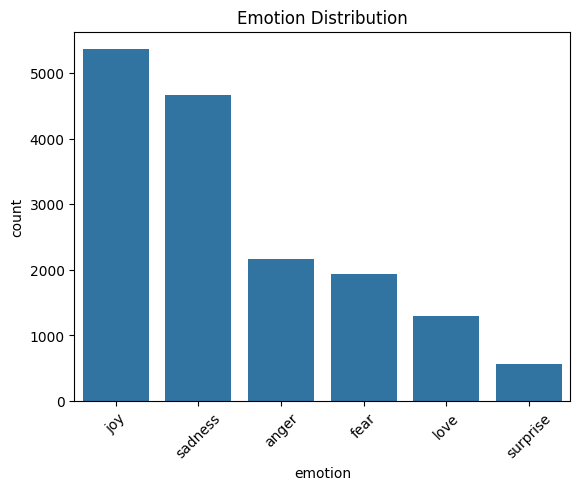

In [ ]:
sns.countplot(x='emotion', data=train_df, order=train_df['emotion'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Emotion Distribution")
plt.show()

**Number of Unique Emotions**

In [ ]:
print("Unique emotions:", train_df["emotion"].nunique())
print("Emotion labels:", train_df["emotion"].unique())

Unique emotions: 6
Emotion labels: ['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


**Length of Texts**

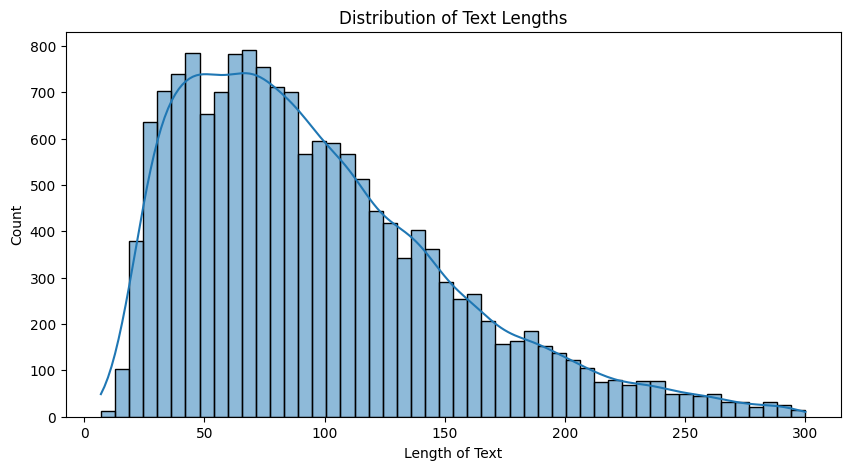

In [ ]:
train_df['text_length'] = train_df['text'].apply(len)

plt.figure(figsize=(10,5))
sns.histplot(train_df['text_length'], bins=50, kde=True)
plt.title("Distribution of Text Lengths")
plt.xlabel("Length of Text")
plt.show()

In [ ]:
print("Duplicates in train:", train_df.duplicated().sum())

Duplicates in train: 1


In [ ]:
train_df.drop_duplicates(inplace=True)

**Common Words (Raw Text)**

In [ ]:
all_words = " ".join(train_df["text"].str.lower()).split()
common = Counter(all_words).most_common(10)
print("Top 10 common words:", common)

Top 10 common words: [('i', 25858), ('feel', 11182), ('and', 9589), ('to', 8971), ('the', 8370), ('a', 6200), ('feeling', 5112), ('that', 5112), ('of', 4990), ('my', 4283)]


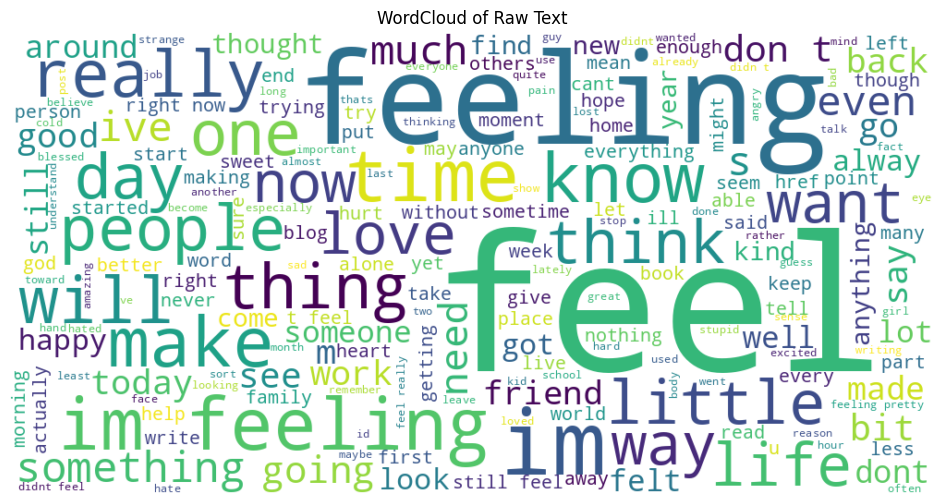

In [ ]:
from wordcloud import WordCloud

text = " ".join(train_df["text"])
wordcloud = WordCloud(width=1000, height=500, background_color="white").generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Raw Text")
plt.show()


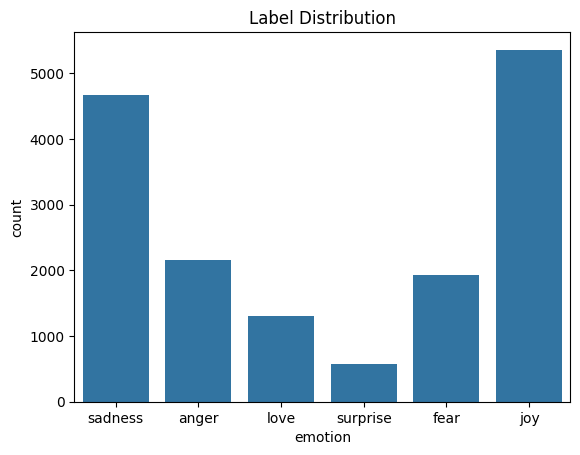

In [ ]:
sns.countplot(x=train_df['emotion'])
plt.title("Label Distribution")
plt.show()

In [ ]:
train_df['emotion'].value_counts()

,count
emotion,
joy,5361
sadness,4666
anger,2159
fear,1937
love,1304
surprise,572


In [ ]:
train_df['emotion'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

# **3. Text Processing**

In [ ]:
nltk.download('punkt') #tokenization
nltk.download('wordnet')  #Stemming & lemmatization
nltk.download('averaged_perceptron_tagger')  #Part-of-Speech Tagging

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
print(stop_words)

{'above', 'each', 'i', 'its', 'until', 'doesn', "they'd", 'about', 'what', 'for', 'she', 'shan', 'up', 'my', "they're", "hadn't", 'who', "shan't", 'nor', 'by', "wouldn't", "i'd", 'into', "won't", 'his', 'further', 'or', "you've", 'we', 'me', "couldn't", 'having', "he'd", "mustn't", 'been', 'it', 'own', 'are', "they've", 'your', 'do', "should've", 'such', "they'll", 'can', 'how', "i've", 'some', 'hers', "it'd", 'isn', 'ma', 'other', 'didn', 'o', "weren't", "you'd", 'out', 'is', 'yours', 'y', 'you', 'while', 'after', 'theirs', 'haven', 'ain', 'her', 'here', 'were', 'mustn', "haven't", "don't", 'being', 'between', 'they', 've', 'below', 're', "aren't", 'ours', "that'll", 'these', 'from', 'on', 'at', "didn't", 't', 'wouldn', 'too', "shouldn't", 'once', 'which', 'am', 'very', 'when', 'hadn', 'yourself', 'd', 'have', 'whom', 'yourselves', 'all', 'mightn', "needn't", 'why', 'now', 'both', "she's", 'more', 'most', 'shouldn', "she'll", 'those', "he'll", 'that', 'only', 'should', 'few', 'm', 'my

In [ ]:
!pip install contractions

import contractions          #expanding contractions


In [ ]:
def clean_text(text):
    # Expand contractions ( can't -> cannot)
    text = contractions.fix(text)

    # Reduce repeated characters
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # Remove non-alphabetic characters
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Lowercase
    text = text.lower()

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Lemmatize and filter
    important_words = {"no", "not", "so", "too", "very"}
    cleaned = [lemmatizer.lemmatize(word) for word in tokens
               if (word in important_words or word not in stop_words) and len(word) > 2]

    return ' '.join(cleaned)

In [ ]:
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
val_df['cleaned_text'] = val_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

In [ ]:
print(train_df[['text', 'cleaned_text']].head())
print('-'*50)
print(val_df[['text', 'cleaned_text']].head())
print('-'*50)
print(test_df[['text', 'cleaned_text']].head())

                                                text  \
0                            i didnt feel humiliated   
1  i can go from feeling so hopeless to so damned...   
2   im grabbing a minute to post i feel greedy wrong   
3  i am ever feeling nostalgic about the fireplac...   
4                               i am feeling grouchy   

                                        cleaned_text  
0                                not feel humiliated  
1  feeling hopeless damned hopeful around someone...  
2             grabbing minute post feel greedy wrong  
3  ever feeling nostalgic fireplace know still pr...  
4                                    feeling grouchy  
--------------------------------------------------
                                                text  \
0  im feeling quite sad and sorry for myself but ...   
1  i feel like i am still looking at a blank canv...   
2                     i feel like a faithful servant   
3                  i am just feeling cranky and blue   
4 

# **Modelling**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the vectorizer and fit it on the training data
tfidf = TfidfVectorizer(max_features=5000)

# Fit the vectorizer on the training data and transform train, validation, and test data
X_train = tfidf.fit_transform(train_df["cleaned_text"])
X_val = tfidf.transform(val_df["cleaned_text"])
X_test = tfidf.transform(test_df["cleaned_text"])
# Labels
y_train = train_df['emotion']
y_val = val_df['emotion']
y_test = test_df['emotion']


In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize model
lr_model = LogisticRegression(max_iter=1000,class_weight='balanced')

# Train model
lr_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on validation data
y_val_pred_lr = lr_model.predict(X_val)

# Evaluation
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred_lr))
print("Classification Report:\n", classification_report(y_val, y_val_pred_lr))

Validation Accuracy: 0.8885
Classification Report:
               precision    recall  f1-score   support

       anger       0.88      0.91      0.89       275
        fear       0.81      0.83      0.82       212
         joy       0.95      0.88      0.91       704
        love       0.76      0.94      0.84       178
     sadness       0.94      0.89      0.91       550
    surprise       0.75      0.90      0.82        81

    accuracy                           0.89      2000
   macro avg       0.85      0.89      0.87      2000
weighted avg       0.89      0.89      0.89      2000



In [ ]:
# Predict on test data
y_test_pred_lr = lr_model.predict(X_test)

# Evaluation
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_lr))

Test Accuracy: 0.88

Classification Report:
               precision    recall  f1-score   support

       anger       0.87      0.91      0.89       275
        fear       0.86      0.83      0.84       224
         joy       0.95      0.87      0.91       695
        love       0.68      0.91      0.78       159
     sadness       0.95      0.89      0.92       581
    surprise       0.58      0.86      0.70        66

    accuracy                           0.88      2000
   macro avg       0.81      0.88      0.84      2000
weighted avg       0.89      0.88      0.88      2000



In [ ]:
nb_model = MultinomialNB()

# Train the model
nb_model.fit(X_train, y_train)

MultinomialNB()

In [ ]:
# Predict on validation data
y_val_pred_nb = nb_model.predict(X_val)

# Evaluation
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred_nb))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred_nb))

Validation Accuracy: 0.747

Classification Report:
               precision    recall  f1-score   support

       anger       0.95      0.55      0.69       275
        fear       0.91      0.43      0.58       212
         joy       0.72      0.97      0.83       704
        love       0.95      0.20      0.33       178
     sadness       0.71      0.95      0.81       550
    surprise       1.00      0.12      0.22        81

    accuracy                           0.75      2000
   macro avg       0.87      0.54      0.58      2000
weighted avg       0.80      0.75      0.71      2000



In [ ]:
# Predict on test data
y_test_pred_nb = nb_model.predict(X_test)

# Evaluation
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_nb))

Test Accuracy: 0.7535

Classification Report:
               precision    recall  f1-score   support

       anger       0.94      0.52      0.67       275
        fear       0.89      0.48      0.62       224
         joy       0.72      0.97      0.83       695
        love       0.97      0.23      0.38       159
     sadness       0.73      0.93      0.82       581
    surprise       0.00      0.00      0.00        66

    accuracy                           0.75      2000
   macro avg       0.71      0.52      0.55      2000
weighted avg       0.77      0.75      0.72      2000



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced')

# Train model
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
# Predict on validation data
y_val_pred_rf = rf_model.predict(X_val)

# Evaluation
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred_rf))
print("Classification Report:\n", classification_report(y_val, y_val_pred_rf))


Validation Accuracy: 0.8815
Classification Report:
               precision    recall  f1-score   support

       anger       0.90      0.87      0.88       275
        fear       0.77      0.86      0.81       212
         joy       0.92      0.90      0.91       704
        love       0.79      0.88      0.83       178
     sadness       0.93      0.89      0.91       550
    surprise       0.77      0.83      0.80        81

    accuracy                           0.88      2000
   macro avg       0.85      0.87      0.86      2000
weighted avg       0.89      0.88      0.88      2000



In [ ]:
# Predict on test data
y_test_pred = rf_model.predict(X_test)

# Evaluation
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

Test Accuracy: 0.8745

Classification Report:
               precision    recall  f1-score   support

       anger       0.88      0.89      0.88       275
        fear       0.84      0.89      0.86       224
         joy       0.90      0.90      0.90       695
        love       0.71      0.82      0.76       159
     sadness       0.96      0.87      0.91       581
    surprise       0.60      0.68      0.64        66

    accuracy                           0.87      2000
   macro avg       0.81      0.84      0.83      2000
weighted avg       0.88      0.87      0.88      2000



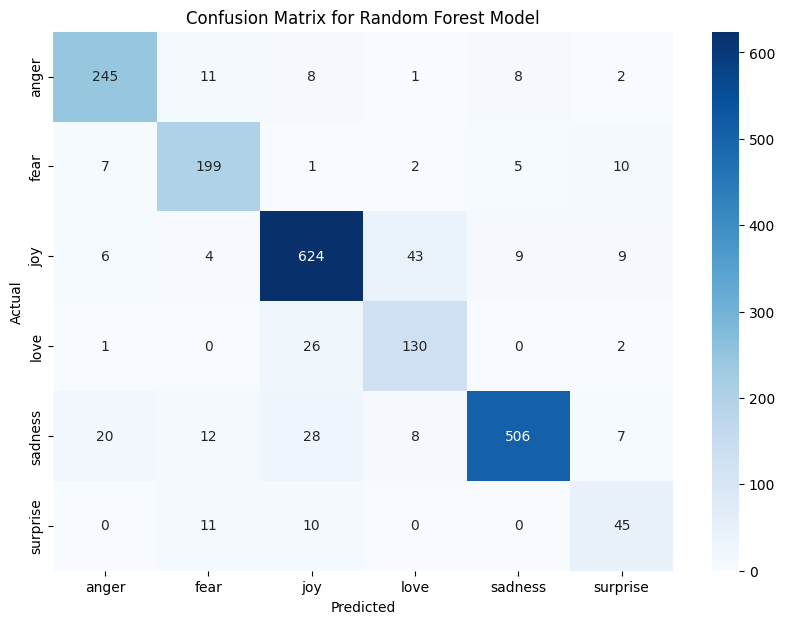

In [ ]:
# Creating the Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plotting the Confusion Matrix using seaborn
plt.figure(figsize=(10,7))  # Set the size of the figure
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
# annot=True: Display the numbers inside the cells, fmt='d': Format as integers, cmap='Blues': Use blue color map
# xticklabels and yticklabels: Label the x and y axes with class names (the emotions)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [ ]:
import joblib
joblib.dump(rf_model, 'emotion_detection_model_rf.joblib')

joblib.dump(tfidf, 'tfidf_vectorizer.joblib')

print("Model and Vectorizer saved successfully!")

Model and Vectorizer saved successfully!


In [ ]:
# Loading the saved model and vectorizer
loaded_rf_model = joblib.load('emotion_detection_model_rf.joblib')
loaded_tfidf = joblib.load('tfidf_vectorizer.joblib')

print("Model and Vectorizer loaded successfully!")

Model and Vectorizer loaded successfully!


In [ ]:
@st.cache_data
def load_model_and_vectorizer():
    rf_model = joblib.load('emotion_detection_model_rf.joblib')
    tfidf = joblib.load('tfidf_vectorizer.joblib')
    return rf_model, tfidf

2025-05-12 07:59:40.848 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [ ]:
# Example of text input (this could come from a user or a chatbot)
new_text = "Oh wow! I didn’t see that coming!"

# Preprocess the text using the loaded vectorizer
new_text_tfidf = loaded_tfidf.transform([new_text])

# Predict the emotion using the loaded model
predicted_emotion = loaded_rf_model.predict(new_text_tfidf)

print(f"The predicted emotion for the input text is: {predicted_emotion[0]}")


The predicted emotion for the input text is: fear


In [ ]:
import spacy
from nltk import CFG
from nltk.parse.generate import generate
from nltk.parse import ChartParser

In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 53.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

# **CFG Example**

In [ ]:
grammar = CFG.fromstring("""
  S -> NP VP
  NP -> PRP
  VP -> V PP
  PP -> P NP2
  NP2 -> Det N RelClause
  RelClause -> PRP Aux V

  PRP -> 'I'
  V -> 'think' | 'said'
  P -> 'about'
  Det -> 'the'
  N -> 'things'
  Aux -> 'have'
""")


sentence = ['I', 'think', 'about', 'the', 'things', 'I', 'have', 'said']


parser = nltk.ChartParser(grammar)


for tree in parser.parse(sentence):
    tree.pretty_print()

      S                                      
  ____|_____                                  
 |          VP                               
 |     _____|_________                        
 |    |               PP                     
 |    |      _________|_____                  
 |    |     |              NP2               
 |    |     |     __________|______           
 NP   |     |    |    |        RelClause     
 |    |     |    |    |      ______|______    
PRP   V     P   Det   N    PRP    Aux     V  
 |    |     |    |    |     |      |      |   
 I  think about the things  I     have   said



In [ ]:
!pip install streamlit pyngrok --quiet

In [ ]:
%%writefile app.py
import streamlit as st
import joblib
import re
import random
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy

# NLTK downloads
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load spaCy model for dependency parsing
nlp = spacy.load("en_core_web_sm")

# Load the trained model and vectorizer
rf_model = joblib.load('emotion_detection_model_rf.joblib')
tfidf = joblib.load('tfidf_vectorizer.joblib')

# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Clean and preprocess text
def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    cleaned = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(cleaned)

# Dependency parsing using spaCy
def extract_dependency_structure(text):
    doc = nlp(text)
    dependencies = [(token.text, token.dep_, token.head.text) for token in doc]
    return dependencies

# Predefined emotion responses
emotion_responses = {
    "sadness": [
        "It's okay to feel sad sometimes. Brighter days are coming 🌈",
        "You're stronger than you think. Take it one step at a time.",
        "Sending you a virtual hug 🤗 You're not alone."
    ],
    "anger": [
        "Take a deep breath. You're in control. 💪",
        "Anger shows you care. Use that energy wisely.",
        "Let it go — peace of mind is worth more. 🧘"
    ],
    "love": [
        "Love makes the world a better place 💖",
        "Cherish the moments of love — they’re priceless.",
        "Your heart is full of warmth. Keep spreading it ❤️"
    ],
    "surprise": [
        "Whoa! Life is full of surprises! 🎉",
        "Stay curious, surprises often lead to blessings.",
        "Keep exploring — surprises mean you’re alive!"
    ],
    "fear": [
        "Fear is just a sign you're about to grow. Keep going! 🚀",
        "You're brave for facing your fears.",
        "Take small steps — you’re doing great!"
    ],
    "joy": [
        "Your joy is contagious! 🌞",
        "Enjoy every moment, life is beautiful.",
        "Happiness is the best medicine — keep smiling! 😄"
    ]
}

# Streamlit UI
st.set_page_config(page_title="Emotion Detection Chatbot", page_icon="🧠")
st.title("🧠 Emotion Detection Chatbot")
st.markdown("💬 Enter a sentence, and the bot will detect the emotion and analyze its structure.")

# User input
user_input = st.text_input("✏️ Enter your sentence:")

if user_input:
    cleaned_input = clean_text(user_input)

    if cleaned_input.strip() == "":
        st.warning("⚠️ Please enter a meaningful sentence with real words.")
    else:
        # Emotion Detection
        vectorized_input = tfidf.transform([cleaned_input])
        prediction = rf_model.predict(vectorized_input)[0]
        st.subheader(f"🔍 Predicted Emotion: **{prediction.capitalize()}**")
        response = random.choice(emotion_responses.get(prediction, ["Keep going, you're doing great!"]))
        st.success(f"💡 {response}")

        # Dependency Parsing Section
        st.markdown("🧱 **Syntactic Structure Analysis**")
        dependencies = extract_dependency_structure(user_input)
        for word, dep, head in dependencies:
            st.write(f"`{word}` → `{dep}` → `{head}`")

Overwriting app.py


In [ ]:
!pip install pyngrok

In [ ]:
!ngrok config add-authtoken 2wpUtLmiaZql7OH0rGs61mT5KEn_21rwZvY1fd7Qb5meBrknC

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok
import os
import time
import subprocess


NGROK_AUTH_TOKEN = "2wpUtLmiaZql7OH0rGs61mT5KEn_21rwZvY1fd7Qb5meBrknC"


os.system(f'ngrok authtoken {NGROK_AUTH_TOKEN}')

# Kill any existing ngrok processes to avoid session conflicts
ngrok.kill()

# Launch the Streamlit app in the background on port 8501, bound to all interfaces (0.0.0.0)
streamlit_process = subprocess.Popen(
    ["streamlit", "run", "app.py", "--server.port", "8501", "--server.address", "0.0.0.0"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True
)

# Wait a few seconds to ensure the app is up and running (increase the time if needed)
time.sleep(25)

# Open an ngrok tunnel on port 8501
public_url = ngrok.connect(8501)
print(f"Streamlit app URL: {public_url}")


Streamlit app URL: NgrokTunnel: "https://c336-34-141-208-219.ngrok-free.app" -> "http://localhost:8501"
